# Notebook to look at relationship between steering muscle spike rate and stroke amplitude

## Imports

In [132]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import glob
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, medfilt
from scipy.interpolate import interp1d, UnivariateSpline

from mosquito.process_abf import load_processed_data, estimate_spike_rate, save_processed_data
from mosquito.util import idx_by_thresh, my_adjust_axes, hampel
from mosquito.read_photron import my_read_cih

## Params

In [38]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels


In [41]:
# hampel filter params
hampel_k = 101  # 201  # 21
hampel_t0 = 0.01

## Load data

In [42]:
# example data trial to start with
data_folder = 48  # 50
axo_num = 0 # 27  # 28

try:
    data = load_processed_data(data_folder, axo_num, data_suffix='_spikes')
except ValueError:
    data = load_processed_data(data_folder, axo_num, data_suffix='_processed')


In [43]:
# read out data variables
t = data['time']
right_amp = data['wing']['right_lead_raw']
left_amp = data['wing']['left_lead_raw']
wbf = data['wbf']
fs = data['sampling_freq']
flying_idx = data['flying_idx'] 


In [44]:
# need to get updated spike rate
if 'good_spike_idx' in data.keys():
    spike_idx = data['good_spike_idx']
else:
    spike_idx = data['spike_idx']

spike_rate = estimate_spike_rate(spike_idx, fs, t.size, win_factor=2*8)


## Filter wing kinematics

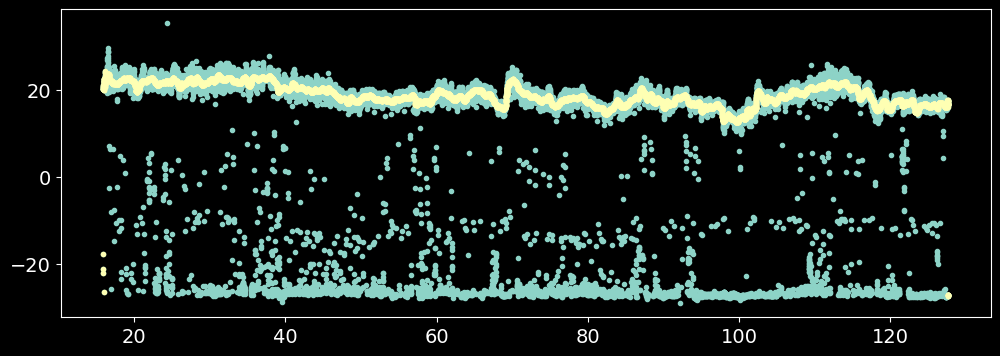

In [45]:
# run hampel filter
signal_raw = left_amp
signal_filt = signal_raw.copy()
nan_idx = np.isnan(signal_filt)
# nan_idx |= (signal_filt < -np.pi/4)

signal_filt[~nan_idx], outlier_idx = hampel(signal_filt[~nan_idx], k=hampel_k, t0=0.01)  # k=21
outlier_idx = np.where(~nan_idx)[0][outlier_idx]

# try to interpolate
signal_interp = np.interp(t, t[~nan_idx], signal_filt[~nan_idx])

# visualize 
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(t, np.rad2deg(signal_raw), '.')
ax.plot(t, np.rad2deg(signal_filt), '.')
# ax.set_xlim([10, 20])

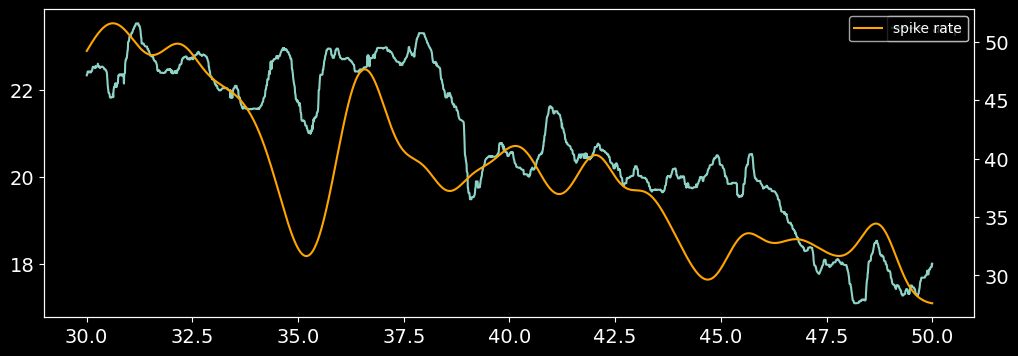

In [62]:
# look at stroke amp and other variables
fig, ax = plt.subplots(figsize=(12,4))

# mask to only look at some of plot
tmin = 30
tmax = 50 # 7 # 5.11
mask = (t >= tmin) & (t <= tmax)

# plot
ax.plot(t[mask], np.rad2deg(signal_interp[mask]), '-', label='amp')
# ax.plot(t[mask], wbf[mask], '-', label='wbf')

ax_twin = ax.twinx()
ax_twin.plot(t[mask], spike_rate[mask], color='orange', label='spike rate')
# ax_twin.plot(t[mask], wbf[mask], color='orange', label='wbf')
ax.legend()
ax_twin.legend()

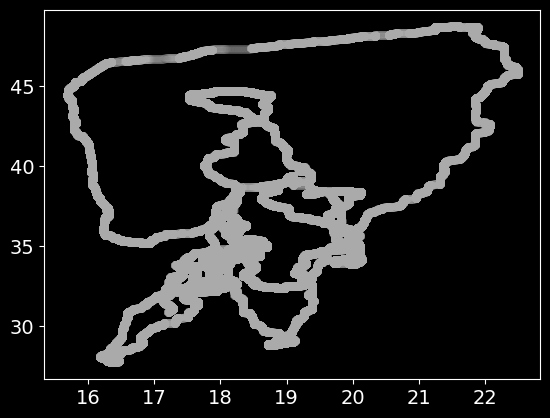

In [49]:
# test plotting vs each other
plt.plot(np.rad2deg(signal_interp[mask]), spike_rate[mask], 'wo', alpha=0.01)

## Same issues as with power muscle spike rate vs wbf -- need to bin(?)

In [50]:
# define bin edges
bin_width = 262144/8  #  262144/4
bin_edges = np.arange(0, wbf.size, bin_width)
bin_idx = np.digitize(np.arange(wbf.size), bin_edges)


In [51]:
# collect data in bins (use pandas)
# # this try statement is used for cross-correlation alignment
# try:
#     spike_rate_in = np.roll(spike_rate, lags[np.argmax(corr)])
#     spike_rate_in = spike_rate_in[flying_idx]
# except:
#     spike_rate_in = spike_rate[flying_idx]
vid_start_idx = np.where(~np.isnan(left_amp))[0][0]
vid_end_idx = np.where(~np.isnan(left_amp))[0][-1]
tmp = np.arange(left_amp.size)
vid_idx = (tmp >= vid_start_idx) & (tmp <= vid_end_idx)

data_idx = flying_idx & vid_idx

d = {'time': t[data_idx], 
     'wbf': wbf[data_idx], 
     'spike_rate': spike_rate[data_idx], 
     'left_amp': signal_interp[data_idx],
     'bin_idx': bin_idx[data_idx]}
df = pd.DataFrame(data=d)

df_binned = df.groupby(['bin_idx']).mean()
# df_binned

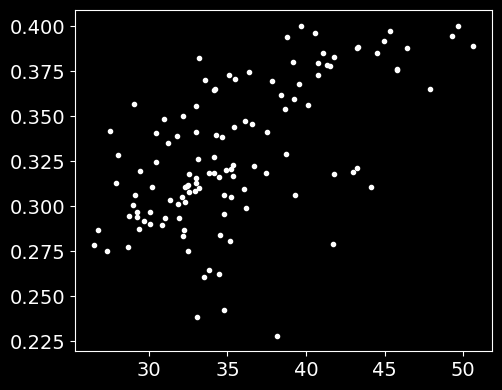

In [57]:
# plot binned results
fig, ax = plt.subplots(figsize=(2*2.5,2*2))

ax.plot(df_binned['spike_rate'][1:-1], df_binned['left_amp'][1:-1], 'w.') # , 'w.', ms=1, alpha=0.4)
#ax.plot(df_binned['spike_rate'][1:-1], m*df_binned['spike_rate'][1:-1] + b, 'r-', lw=0.75)

# ax.set_xlabel('burst rate (Hz)')
# ax.set_ylabel('wingbeat freq. (Hz)')

fig.tight_layout()


In [53]:
df_binned[['wbf', 'left_amp', 'spike_rate']][1:-1].corr()

,wbf,left_amp,spike_rate
wbf,1.000000,0.025169,0.317984
left_amp,0.025169,1.000000,0.607033
spike_rate,0.317984,0.607033,1.000000
